In [1]:
import mido # easy to use python MIDI library
import numpy as np # linear algebra
import os # accessing directory structure
import time
from mido import MidiFile, MidiTrack, Message
from IPython.display import Audio, clear_output

In [2]:
os.listdir()

['Music-GPT-tf2.ipynb',
 '.ipynb_checkpoints',
 'preprocessing.ipynb',
 'WaveGan.ipynb',
 'baseline_blue.ipynb',
 'wavenet_gen_gloss.npy',
 '0612_wavenet_dis_dloss.npy',
 'generator.h5',
 'MusicTransformer.ipynb',
 'new_song4.mid',
 'WaveGan-waveform_version.ipynb',
 '0612_wavenet_gen_gloss.npy',
 'wavenet_dis_dloss.npy',
 'new_song3.mid',
 'blues.zip',
 'data_midi.zip',
 'baseline_all.ipynb',
 'new_song_5.mid',
 'blues',
 'data_midi',
 'Bidirectional_GRU_GAN.ipynb',
 'new_song1.mid']

In [3]:
paths = []
songs = []
#append every filepath in the blues folder to paths[]
for r, d, f in os.walk("./data_midi"):
    for file in f:
        if '.mid' in file:
            paths.append(os.path.join(r, file))

#for each path in the array, create a Mido object and append it to song[]
for path in paths:
    mid = MidiFile(path, type = 1)
    songs.append(mid)
del paths

In [4]:
len(songs)

400

In [6]:
notes = []
dataset = []
chunk = []

# for each in midi object in list of songs
for i in range(len(songs)):
    # for each note in midi object
    for msg in songs[i]:
        # filtering out meta messages
        if not msg.is_meta:
            # filtering out control changes
            if (msg.type == 'note_on'):
                # normalizing note and velocity values
                notes.append(msg.note)
    for i in range(1, len(notes)):
        chunk.append(notes[i])
    dataset.append(chunk)
    chunk = []
    notes = []
    
del chunk
del notes

In [7]:
np.array(dataset).shape

(400,)

In [8]:
notes = []
dataset = []
chunk = []
SEQ_LEN=256

#for each in midi object in list of songs
for i in range(len(songs)):
    #for each note in midi object
    for msg in songs[i]:
        #filtering out meta messages
        if not msg.is_meta:
            #filtering out control changes
            if (msg.type == 'note_on'):
                #normalizing note and velocity values
                notes.append(msg.note)
    for i in range(1, len(notes)):
        chunk.append(notes[i])
        #save each 16 note chunk
        if (i % SEQ_LEN == 0):
            dataset.append(chunk)
            chunk = []
    chunk = []
    notes = []
del chunk
del notes

In [9]:
train_data = np.array(dataset)
train_data.shape

(17165, 256)

In [10]:
# Rescale 0 to 1
train_data = train_data / 128

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model

In [12]:
train_data = train_data.reshape(len(dataset),SEQ_LEN,1)
train_data.shape

(17165, 256, 1)

In [42]:
# train_data[2]

In [17]:
#  def build_generator():

#         model = Sequential([
#         Bidirectional(LSTM(128, return_sequences=True), input_shape=(4, 4)),
#         LeakyReLU(alpha=0.2),
#         Bidirectional(LSTM(128, return_sequences=True)),
#         LeakyReLU(alpha=0.2),
#         Bidirectional(LSTM(128)),
#         LeakyReLU(alpha=0.2),
#         # specifying output to have 40 timesteps
#         RepeatVector(16),
#         # specifying 1 feature as the output
#         Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)),
#         LeakyReLU(alpha=0.2),
#         Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)),
#         LeakyReLU(alpha=0.2),
#         Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2)),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.3),
#         TimeDistributed(Dense(128)),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.4),
#         TimeDistributed(Dense(128)),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.4),
#         TimeDistributed(Dense(1)),
#         # back to 0 ~ 1
#         Activation("sigmoid"),
#         ])
#         model.summary()
#         noise = Input(shape=(4,4))
#         img = model(noise)
#         return Model(noise, img)


In [13]:
from tensorflow.keras.layers import Conv1D,Multiply,Add,Conv1DTranspose

def dilated_causal_Conv1D(dilation_r,activation_fn,dilated_num=0,num_stack=0):
    return Conv1D(filters=NUM_FILT,
    kernel_size=2,
    strides=1,
    padding="causal", #valid
    dilation_rate=dilation_r,
    activation=activation_fn,
    use_bias=True,
    name='%s_stack%d_dilated%d_causal_conv_layer'%(activation_fn,num_stack,dilated_num))

def Conv1D_11(filter_n):
    return Conv1D(filters=filter_n,
                 kernel_size=1,
                 padding='same',
                 use_bias=True,
                 kernel_regularizer=None)
def residualBlock(x,dilated_num,num_stack):
    #dilated_causal_Conv1D
    tanh_out=dilated_causal_Conv1D(2**dilated_num,'tanh',dilated_num,num_stack)(x)
    sig_out=dilated_causal_Conv1D(2**dilated_num,'sigmoid',dilated_num,num_stack)(x)
    #gate
    gate_out=Multiply()([tanh_out,sig_out])
    #1*1 conv
    res_x=Conv1D_11(NUM_FILT)(gate_out)
    #skip connection
    skip_x=res_x
    #residual
    res_x=Add()([x,res_x])
    return skip_x,res_x
from tensorflow.keras.layers import Add,Activation,Input,Flatten,Dense,MaxPool1D,AveragePooling1D,Reshape
from tensorflow.keras.models import Model

def build_model(in_shape):
    input_x=Input(shape=(in_shape,1,),name='input_layer')
    
    #label_x=Input(shape=(NUM_CLASS,),name='global_condition')
    
    #first causal convolution(dilation=1) before into residual blocks
    x=input_x
    _=dilated_causal_Conv1D(1,None,-1,-1)(x)
    
    #residual blocks
    skip_connection=[]
    res_x=_
    for j in range(NUM_STACKS):
        for i in range(DILAT_DEPTH+1): #dilation to 512
            skip_x,res_x=residualBlock(res_x,i,j)
            #store skip connection for postprocessing
            skip_connection.append(skip_x)
            
    #post processing
    #post processing
    out=Add()(skip_connection)
    out=Activation('relu')(out)
    out=Conv1D_11(VAL_DIM*32)(out)
#     out=Conv1DTranspose(1,1,strides=2)(out)
    out=Activation('relu')(out)
    out=Conv1D_11(VAL_DIM*8)(out)
    out=Activation('relu')(out)
    out=Conv1D_11(VAL_DIM)(out)
#     out=Conv1DTranspose(1,1,strides=2)(out)
    out=Activation('sigmoid')(out) 
#     out=Add()(skip_connection)
#     out=Activation('relu')(out)
#     out=Conv1D(NUM_FILT, 80, strides=1, padding='same', name='conv_5ms')(out)#, activation='relu')(out)
# #     out = AveragePooling1D(80, padding='same', name='downsample_to_1110Hz')(out)
    
    
    #paper
#     out = Conv1D(NUM_FILT, 100, padding='same', activation='relu', name='conv_500ms')(out)
#     out = Conv1D(NUM_CLASS, 100, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
#     out = AveragePooling1D(100, padding='same', name='downsample_to_2Hz')(out)
#     out = Conv1D(NUM_CLASS, (int)(IN_LENGTH*freq/ 8000), padding='same', name='final_conv')(out)
#     out = AveragePooling1D((int)(IN_LENGTH*freq / 8000), name='final_pooling')(out)
#     out = Reshape((NUM_CLASS,))(out)
#     out = Activation('softmax')(out)

    model=Model(inputs=input_x,outputs=out)
    
    return model

In [14]:
DILAT_DEPTH=4 #14 #13
NUM_STACKS=1 #2
RECEPTIVE_FIELD=NUM_STACKS*2**(DILAT_DEPTH)*2
# SEQ_LEN=30*22050 #GTZAN seconds*HZ
VAL_DIM=1 #256
NUM_FILT=64
print('receptive field:',RECEPTIVE_FIELD)
model=build_model(SEQ_LEN)
model.summary()

receptive field: 32
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
None_stack-1_dilated-1_causal_c (None, 256, 64)      192         input_layer[0][0]                
__________________________________________________________________________________________________
tanh_stack0_dilated0_causal_con (None, 256, 64)      8256        None_stack-1_dilated-1_causal_con
__________________________________________________________________________________________________
sigmoid_stack0_dilated0_causal_ (None, 256, 64)      8256        None_stack-1_dilated-1_causal_con
___________________________________________________________________

In [15]:
generator=build_model(SEQ_LEN)

In [16]:
def build_discriminator():
    model=Sequential([
        Conv1D(32,(3),strides=(2),input_shape=(SEQ_LEN,1,)),
        LeakyReLU(),
        Conv1D(64, (3), strides=(2), padding='same',use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
#         Conv1D(128, (3), strides=(2), padding='same',use_bias=False),
#         BatchNormalization(),
#         LeakyReLU(),
        Conv1D(64, (3), strides=(2), padding='same',use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Flatten(),
        Dense(1)
    ])
    model.summary()
    return model

In [17]:
#  def build_discriminator():

#         model = Sequential([
    
#                 Bidirectional(LSTM(128, return_sequences=True), input_shape=(SEQ_LEN,1)),#16, 1)),
#                 Activation("relu"),
#                 LeakyReLU(alpha=0.2),
#                 Bidirectional(LSTM(128)),
#                 Activation("relu"),
#                 LeakyReLU(alpha=0.2),
#                 Dropout(0.4),
#                 RepeatVector(1),
#                 TimeDistributed(Dense(128, activation = 'sigmoid')),
#                 LeakyReLU(alpha=0.2),
#                 Dropout(0.4),
#                 TimeDistributed(Dense(128, activation = 'relu')),
#                 LeakyReLU(alpha=0.2),
#                 Dropout(0.4),
#                 TimeDistributed(Dense(1, activation = 'linear'))
#         ])
            
#         model.summary()

#         img = Input(shape=(SEQ_LEN,1))
#         validity = model(img)

#         return Model(img, validity)
    

In [37]:
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# generator = build_generator()

In [18]:
# Build and compile the discriminator
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator = build_discriminator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 127, 32)           128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 127, 32)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 64, 64)            6144      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64)            256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 32, 64)            12288     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64)            2

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
@tf.function
def train_step(music):
    noise = tf.random.normal([Batch,SEQ_LEN,1])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
         
        generated_music = generator(noise, training=True)
        real_output = discriminator(music, training=True)
        fake_output = discriminator(generated_music, training=True)
  
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [22]:
gloss_list=[]
dloss_list=[]
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        G_loss = 0
        D_loss = 0
#         print('len(dataset)',len(dataset))
        for i,image_batch in enumerate(dataset):
            gen_loss,disc_loss = train_step(image_batch)
            print(f"Step：{i} | G_loss：{gen_loss} D_loss：{disc_loss}|")
            G_loss += gen_loss
            D_loss += disc_loss
        clear_output(wait=True)
        print (f'Time for epoch {epoch + 1} is {time.time()-start} sec\n')
        print(f'G_AVE_Loss：{G_loss/len(dataset)}')
        print(f'D_AVE_loss：{D_loss/len(dataset)}')
        gloss_list.append(G_loss/len(dataset))
        dloss_list.append(D_loss/len(dataset))
        if epoch % 100 == 0:
            generator.save("generator.h5")
    np.save('0612_wavenet_gen_gloss.npy', np.array(gloss_list))
    np.save('0612_wavenet_dis_dloss.npy',np.array(dloss_list))

In [24]:
Batch = 32#128
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(Batch,drop_remainder=True)

In [25]:
train_dataset

<BatchDataset shapes: (32, 256, 1), types: tf.float64>

In [58]:
with tf.device('/device:GPU:2'):
    train(train_dataset,100)

Time for epoch 100 is 7.07942008972168 sec

G_AVE_Loss：1.1319727897644043
D_AVE_loss：1.0222206115722656


In [59]:
#31s,8.6s...etc

# Plot

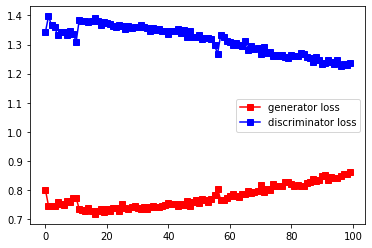

In [28]:
#epoch100
import matplotlib.pyplot as plt
import numpy as np
g=np.load('0612_wavenet_gen_gloss.npy')
# month = [i for i in range(len(g))]
plt.plot(g,'s-',color = 'r', label="generator loss")
d=np.load('0612_wavenet_dis_dloss.npy')
plt.plot(d,'s-',color = 'b', label="discriminator loss")
plt.legend(loc = "best", fontsize=10)
plt.show()

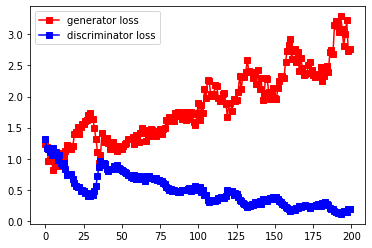

In [122]:
#epoch200
import matplotlib.pyplot as plt
import numpy as np
g=np.load('0612_wavenet_gen_gloss.npy')
month = [i for i in range(len(g))]
plt.plot(g,'s-',color = 'r', label="generator loss")
d=np.load('0612_wavenet_dis_dloss.npy')
plt.plot(d,'s-',color = 'b', label="discriminator loss")
plt.legend(loc = "best", fontsize=10)
plt.show()

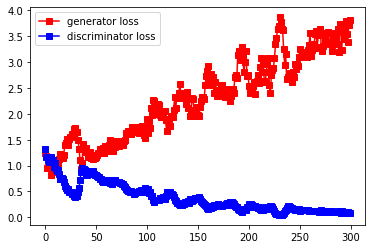

In [127]:
#epoch300
import matplotlib.pyplot as plt
import numpy as np
g=np.load('0612_wavenet_gen_gloss.npy')
month = [i for i in range(len(g))]
plt.plot(g,'s-',color = 'r', label="generator loss")
d=np.load('0612_wavenet_dis_dloss.npy')
plt.plot(d,'s-',color = 'b', label="discriminator loss")
plt.legend(loc = "best", fontsize=10)
plt.show()

# Output

In [55]:
random = np.random.normal(0,1,(1,SEQ_LEN,1))
with tf.device('/device:GPU:2'):
    predict = generator.predict(random)
predict = predict*128

In [56]:
predict

array([[[52.188732],
        [56.32511 ],
        [56.280106],
        [76.55041 ],
        [61.409657],
        [74.56762 ],
        [58.61628 ],
        [58.4349  ],
        [70.593864],
        [74.00828 ],
        [59.273773],
        [75.76487 ],
        [63.642647],
        [60.56993 ],
        [59.594517],
        [77.44644 ],
        [61.219376],
        [71.113815],
        [55.086315],
        [65.8428  ],
        [77.99266 ],
        [56.427612],
        [49.50969 ],
        [76.96218 ],
        [78.20231 ],
        [52.684017],
        [77.20884 ],
        [75.53047 ],
        [55.096725],
        [78.42056 ],
        [78.92731 ],
        [74.834526],
        [79.2553  ],
        [78.57518 ],
        [55.50969 ],
        [56.952038],
        [72.75229 ],
        [80.58212 ],
        [76.744354],
        [66.12913 ],
        [79.38108 ],
        [75.62054 ],
        [76.75917 ],
        [81.215546],
        [75.12194 ],
        [76.47251 ],
        [74.31479 ],
        [64.9

In [104]:
# midler = MidiFile()
# track = MidiTrack()
# track.append(Message('program_change', program=2, time=0))
# for x in range(predict.shape[1]):
#     print(int(predict[0][x][0]))
#     track.append(Message('note_on', note=int(predict[0][x][0]), velocity=4, time=20))
#     track.append(Message('note_off', note=int(predict[0][x][0]), velocity=4, time=20))
#     midler.save('new_song.mid')

In [60]:
midler = MidiFile()
track = MidiTrack()
midler.tracks.append(track)
track.append(Message('program_change', program=2, time=0))
for x in range(SEQ_LEN):
    interval=np.random.randint(20,100,size=1)
    note_int=np.random.randint(20,200,size=1)
    change_int=np.random.randint(1,40,size=1)
    control=np.random.randint(0,2,size=1)[0]
    value=np.random.randint(30,80,size=1)[0]
    if control>1:
        control=64
        value=np.random.randint(0,128,size=1)[0]
    track.append(Message('note_on', channel=1,note=int(predict[0][x][0]), velocity=64, time=interval[0]))
    if control==64:
        track.append(Message('control_change',channel=1,control=control,value=value,time=change_int[0]))
#         print(control,value)
    track.append(Message('note_off', channel=1,note=int(predict[0][x][0]), velocity=64, time=note_int[0]))
    midler.save('new_song_all.mid')